In [ ]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 69.3 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
import itertools
import random

from typing import Dict, Optional, Union, List
from collections import defaultdict
import matplotlib.pyplot as plt
import sys
import math
import random
import cv2
from IPython.display import Image




np.warnings.filterwarnings('ignore')

[[19 19 18 ...  1  0  0]
 [19 19 18 ...  1  0  0]
 [19 19 18 ...  1  0  0]
 ...
 [10 10 10 ... 15 15 15]
 [10 10 10 ... 15 15 15]
 [10 10 10 ... 15 15 15]]
(128, 128)
(16384, 1)


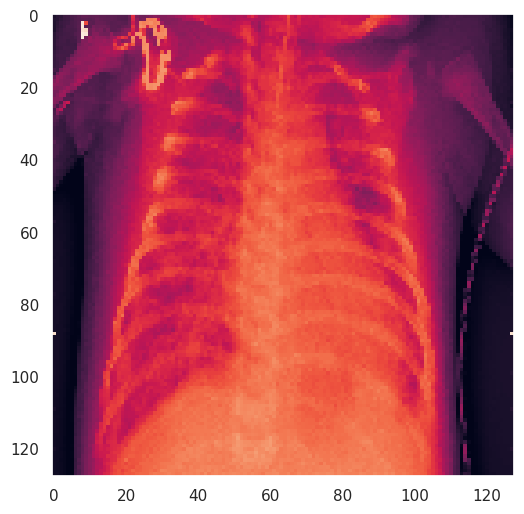

In [ ]:
img = cv2.imread('', cv2.IMREAD_GRAYSCALE)
print(img)
img= cv2.resize(img,(128, 128))
print(img.shape)
plt.figure(figsize=(6, 6))
plt.grid(False)
plt.imshow(img)
pixel_values = img.reshape((-1, 1))
print(pixel_values.shape)
pixel_values = np.float32(pixel_values)

In [ ]:
k_clusters=3
batch_size=32
num_qubits_centroid = math.ceil(math.log2(k_clusters))
num_qubits_train = math.ceil(math.log2(len(pixel_values)))-math.ceil(math.log2(batch_size))
centroid_comp_basis_states = list(itertools.product(['0', '1'], repeat=num_qubits_centroid))
train_comp_basis_states = list(itertools.product(['0', '1'], repeat=num_qubits_train))

In [ ]:
print(len(pixel_values))

16384


In [ ]:
dev_dist_calc = qml.device("lightning.qubit", wires=num_qubits_train+num_qubits_centroid+3, shots=1000000)

In [ ]:
def where_to_apply_x(bin_number_length: int) -> List:

    indices=[]
    powers_of_two = 2 ** np.arange(bin_number_length)
    for pos in range(2**bin_number_length):
        temp=[]
        for ind, v in enumerate(powers_of_two):
            if v & (pos ^ (pos - 1)) == v:
                temp.append(ind)
        indices.append(temp)
    #indices = [[ind for ind, v in enumerate(powers_of_two) if v & (pos ^ (pos - 1)) == v] for pos in range(2 ** bin_number_length)]
    return indices

In [ ]:
#@title
def layer(param, control_wires, target_wires):
    param=param/255*np.pi
    qml.MultiControlledX(control_wires, target_wires)
    qml.RY(-1*param/2, target_wires)
    qml.MultiControlledX(control_wires, target_wires)
    qml.RY(param/2, target_wires)

In [ ]:
#@title
@qml.qnode(dev_dist_calc)
def distance_circuit(data, centroids):
    
    ctrl_wires_training=[i for i in range(2,2+math.ceil(math.log2(len(data))))]
    train_bin_number_length = len(ctrl_wires_training)
    where_x_train = where_to_apply_x(train_bin_number_length)

    for i in range(2,2+math.ceil(math.log2(len(data)))):
        qml.Hadamard(wires=i)
    for i in range(2**train_bin_number_length):
        for j in where_x_train[i]:
            qml.PauliX(2+train_bin_number_length-1-j)
        if i<len(data):
            layer(data[i][0], ctrl_wires_training, [1])

    if len(centroids)>1:
        ctrl_wires_centroids=[i for i in range(2+math.ceil(math.log2(len(data)))+1,2+math.ceil(math.log2(len(data)))+1+math.ceil(math.log2(len(centroids))))]
        centroid_bin_number_length = len(ctrl_wires_centroids)
        where_x_centroids = where_to_apply_x(centroid_bin_number_length)

        for i in range(2+math.ceil(math.log2(len(data)))+1, 2+math.ceil(math.log2(len(data)))+1+math.ceil(math.log2(len(centroids)))):
            qml.Hadamard(wires=i)
        for i in range(2**centroid_bin_number_length):
            for j in where_x_centroids[i]:
                qml.PauliX(2+train_bin_number_length+centroid_bin_number_length-j)
            if i<len(centroids):
                layer(centroids[i][0], ctrl_wires_centroids, [2+math.ceil(math.log2(len(data)))])
    
    else:
        qml.PauliX([2+math.ceil(math.log2(len(data)))+1])
        layer(centroids[0][0], [2+math.ceil(math.log2(len(data)))+1], [2+math.ceil(math.log2(len(data)))])
        qml.PauliX([2+math.ceil(math.log2(len(data)))+1])
    
    qml.Hadamard(wires=[0])
    qml.CSWAP(wires=[0,1,2+math.ceil(math.log2(len(data)))])
    qml.Hadamard(wires=[0])

    if len(centroids)>1:
        return qml.counts(wires=[0]+ctrl_wires_training+ctrl_wires_centroids)
    else:
        return qml.counts(wires=[0]+ctrl_wires_training+[2+math.ceil(math.log2(len(data)))+1])

In [ ]:
centroids=random.sample(list(pixel_values), k_clusters)
print(centroids)

[array([114.], dtype=float32), array([185.], dtype=float32), array([162.], dtype=float32)]


In [ ]:
def get_distance(data, centroids):
    k=len(centroids)
    all_counts=distance_circuit(data, centroids)
    num_qubits_centroid_init=math.ceil(math.log2(len(centroids)))
    if num_qubits_centroid_init==0:
        centroid_comp_basis_states_init=[('0')]
    else:
        centroid_comp_basis_states_init = list(itertools.product(['0', '1'], repeat=num_qubits_centroid_init))
    mixed_measurements = list(all_counts)
    dist=[]
    for c in centroid_comp_basis_states_init[:k]:
        if k==1:
            c=''.join(c[-1])
        else:
            c=''.join(c)
        subsystems_counts = [defaultdict(int) for _ in range(2)]
        for mixed_measurement in mixed_measurements:
            subsystem_measurements = [mixed_measurement[0], mixed_measurement[1:1+num_qubits_train], mixed_measurement[1+num_qubits_train:]]
            if subsystem_measurements[2]==c:
                count=all_counts[mixed_measurement]
                for k, d_l in zip([subsystem_measurements[0],subsystem_measurements[1]], subsystems_counts):
                    d_l[k] += count


        setup_counts=[dict(d) for d in subsystems_counts]
        control_counts=setup_counts[0]
        train_counts=setup_counts[1]
        distances = np.zeros(len(data), dtype=float)

        for comp_state in train_comp_basis_states[:len(data)]:
            comp_state = ''.join(comp_state)
            state_str_0 = '0'+comp_state+c
            #state_str_1 = '1'+comp_state+c
            p_0_i=all_counts.get(state_str_0,0) / train_counts[comp_state]
            #p_1_i=all_counts.get(state_str_1,0) / train_counts[comp_state]
            fidelity=(2*p_0_i)-1
            index_state = int(comp_state, 2)
            distances[index_state] = 1-fidelity

        dist.append(distances)

    return np.transpose(dist)

In [ ]:
def init_centroids_qunatum(data, k):
    '''
    initialized the centroids for K-means++
    inputs:
        data - numpy array of data points having shape (200, 2)
        k - number of clusters
    '''
    ## initialize the centroids list and add
    ## a randomly selected data point to the list
    centroids = []
    centroids.append(data[0, :])
    print(centroids)
    n_samples=len(data)
    size=n_samples//batch_size
    for c_id in range(k - 1): 
        print(c_id)
        main_d=[]
        for b in range(batch_size):
            print(b)
            ## initialize a list to store distances of data points from nearest centroid
            sample_data=data[size*b:size*(b+1),:]
            dist = get_distance(sample_data, centroids)
            l=[]
            for i in dist:
                l.append(min(i))
            main_d.append(l)

        l=np.array(main_d)
        ## select data point with maximum distance as our next centroid
        probs = l/l.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        print(len(probs))
        for j, p in enumerate(cumulative_probs):
            if np.isnan(p):
              p=1
            if r < p:
                i = j
                break
        
        centroids.append(pixel_values[i])
        #centroids.append(next_centroid)
        dist = []
        print(centroids)
        
    return centroids

In [ ]:
centroids=init_centroids_qunatum(pixel_values, k_clusters)
converge=False
print(centroids)

[array([19.], dtype=float32)]
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
[array([19.], dtype=float32), array([185.], dtype=float32)]
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
[array([19.], dtype=float32), array([185.], dtype=float32), array([116.], dtype=float32)]
[array([19.], dtype=float32), array([185.], dtype=float32), array([116.], dtype=float32)]


In [ ]:
print(len(pixel_values))

16384


In [ ]:
i=0
n_samples=len(pixel_values)
size=n_samples//batch_size
while not converge:
    i+=1
    labels=[]
    for b in range(batch_size):
        sample_data=pixel_values[size*b:size*(b+1),:]
        distance=get_distance(sample_data, centroids)
        for d in distance:
            labels.append(np.argmin(d))

    labels=np.array(labels)
    new_centers = np.array([pixel_values[labels == i].mean(0) for i in range(k_clusters)])
    new_centroids=(np.rint(new_centers)).astype(int)
    if np.sum(np.abs(np.subtract(centroids, new_centroids)))<=15:
        break
    print(new_centroids)
    centroids=new_centroids

In [ ]:
print(i)

In [ ]:
print(len(labels))
print(centroids)

In [ ]:
y_pred = labels.astype(int)
labels = y_pred.flatten()
segmented_image = centroids[labels.flatten()]
segmented_image = segmented_image.reshape(img.shape)
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image, cmap='Greys_r')
plt.grid(False)
plt.show()
im = Image.fromarray(segmented_image)
im.save("K_Means.jpg")

In [ ]:
print(centroids)